In [50]:
import os, sys
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

sys.path.append('..')
from script.utils import *
from Class.PlotConfig import *
from Class.Plotter import *

figPath = '../results/'

In [51]:
first_date = to_datetime('02-29-2020')
last_date = to_datetime('05-17-2022')
# last_date = to_datetime('12-29-2021')

In [4]:
print('Loading original')
df = pd.read_csv('../2022_May/Total.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]
original = df.describe().reset_index()
# print(original)

print('Loading cleaned')
df = pd.read_csv('../2022_May_cleaned/Total.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]
cleaned = df.describe().reset_index()
# print(cleaned)

Loading cleaned


In [7]:
original = original.round(3)
cleaned = cleaned.round(3)

stats = ['mean', 'std']
for feature in cleaned.columns:
    # ignore index and calculated features
    if feature in ['index', 'FIPS', 'LinearSpace', 'SinWeekly', 'CosWeekly', 'TimeFromStart']: continue

    line = feature
    for stat in stats:
        value = original[original['index']==stat][feature].values[0]
        line += f' & {value}'

    for stat in stats:
        value = cleaned[cleaned['index']==stat][feature].values[0]
        line += f' & {value}'
    line += ' \\\\'
    print(line)

AgeDist & 0.576 & 0.094 & 0.576 & 0.094 \\
HealthDisp & 0.368 & 0.198 & 0.368 & 0.198 \\
DiseaseSpread & 0.15 & 0.194 & 0.15 & 0.193 \\
Transmission & 0.492 & 0.21 & 0.491 & 0.21 \\
VaccinationFull & 20.609 & 22.922 & 20.609 & 22.923 \\
SocialDist & 0.784 & 0.228 & 0.795 & 0.229 \\
Cases & 31.667 & 337.405 & 27.183 & 174.15 \\
Deaths & 0.378 & 2.853 & 0.239 & 2.244 \\


In [ ]:
# df = pd.DataFrame({'FIPS':[1, 2], '2020-02-20':[1, 2], '2020-02-19':[2, 4], '2020-02-21':[10, 4], 
# '2020-02-22':[3, 1], '2020-02-23':[5, 4], '2020-02-24':[3, 8], '2020-02-25':[6, 4], '2020-02-26':[3, 4]})
# id_vars = [col for col in df.columns if not valid_date(col)]
# date_columns = [col for col in df.columns if col not in id_vars]
# date_columns = sorted(date_columns)
# df = df[id_vars+date_columns]
# df

In [52]:
targets = ['Cases', 'Deaths']
total_raw =  pd.read_csv('../2022_May/Total.csv')[['Date'] + targets]
total_raw = total_raw.groupby(['Date'])[targets].aggregate('sum').reset_index()

total_cleaned =  pd.read_csv('../2022_May_cleaned/Total.csv')[['Date'] + targets]
total_cleaned = total_cleaned.groupby(['Date'])[targets].aggregate('sum').reset_index()

total_smoothed =  pd.read_csv('../2022_May_cleaned_moving_averaged/Total.csv')[['Date'] + targets]
total_smoothed = total_smoothed.groupby(['Date'])[targets].aggregate('sum').reset_index()

In [53]:
for df in [total_raw, total_cleaned, total_smoothed]:
    df['Date'] = to_datetime(df['Date'])

In [ ]:
import numpy as np

# ['AgeDist', 'HealthDisp']
static = np.array([1194937.8750,  731108.5625])

# ['LinearSpace', 'SinWeekly', 'CosWeekly', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist', 'Cases', 'Deaths'],
encoder = np.array([ 70234.0938, 266382.2500, 166733.8750, 119877.3047,  86451.5547,
        152106.8438,  93373.2109, 663901.0625, 306985.7812])

# # ['LinearSpace', 'SinWeekly', 'CosWeekly'] 
decoder = np.array([762799.0625, 713305.5625, 449941.6250])
for arr in [static, encoder, decoder]:
    print(arr*100/arr.sum())

In [ ]:
target_df = total_cleaned
target_df.head()

In [ ]:
def plot(df, target, scale:int=1e3, x_major_ticks:int=DATE_TICKS, figure_name:str=None):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x_column = 'Date'

    plt.plot(df[x_column], df[target])
    plt.ylim(bottom=0)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    plt.xticks(rotation = 15)
        
    if scale>1:
        if scale==1e3 or scale==1e6:
            label_text = [] 
            if scale ==1e3: unit = 'K'
            else: unit = 'M'

            for loc in plt.yticks()[0]:
                if loc == 0:
                    label_text.append('0')
                else:
                    label_text.append(f'{loc/scale:0.5g}{unit}') 

            ax.set_yticklabels(label_text)
            plt.ylabel(f'Daily {target}')
        else:
            ax.yaxis.set_major_formatter(get_formatter(scale))
            if scale==1e3: unit = 'in thousands'
            elif scale==1e6: unit = 'in millions'
            else: unit = f'x {scale:.0e}'

            plt.ylabel(f'Daily {target} ({unit})')
    else:
        plt.ylabel(f'Daily {target}')

    fig.tight_layout()

    if figure_name is not None:
        plt.savefig(os.path.join(figPath, figure_name), dpi=DPI)
    plt.show()

In [ ]:
for target in targets:
    if target=='Cases':
        plot(total_raw, target, figure_name=f'{target}_original.jpg', scale=1e6)
    else:
        plot(total_raw, target, figure_name=f'{target}_original.jpg')

    plot(total_cleaned, target, figure_name=f'{target}_cleaned_iqr_7.5.jpg')
    plot(total_smoothed, target, figure_name=f'{target}_cleaned_iqr_7.5_7_day_moving_averaged.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for target in targets:
    plt.plot(total_raw['Date'], total_raw[target], label=target)

x_first_tick = total_raw['Date'].min()
x_last_tick = total_raw['Date'].max()
x_major_ticks = DATE_TICKS
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
plt.xticks(rotation = 15)
plt.yscale('log')
plt.ylabel(f'Daily count (log scaled)')

plt.legend()
fig.tight_layout()
plt.savefig(os.path.join(figPath, 'Combined-log-scaled.jpg'), dpi=DPI)
plt.show()

In [54]:
splits =  {
    'Primary': [to_datetime('2021-11-29'), (-100, 120)],
    'Rising 3rd Wave': [to_datetime('2021-12-31'), (-120, 150)],
    'Falling 3rd Wave': [to_datetime('2022-01-31'), (0, 220)],
    'Post 3rd Wave': [to_datetime('2022-02-28'), (0, 180)]
}
df = total_cleaned

In [55]:
target  ='Cases'
scale=1e6
x_major_ticks=DATE_TICKS
x_column = 'Date'

dates = df[x_column].values

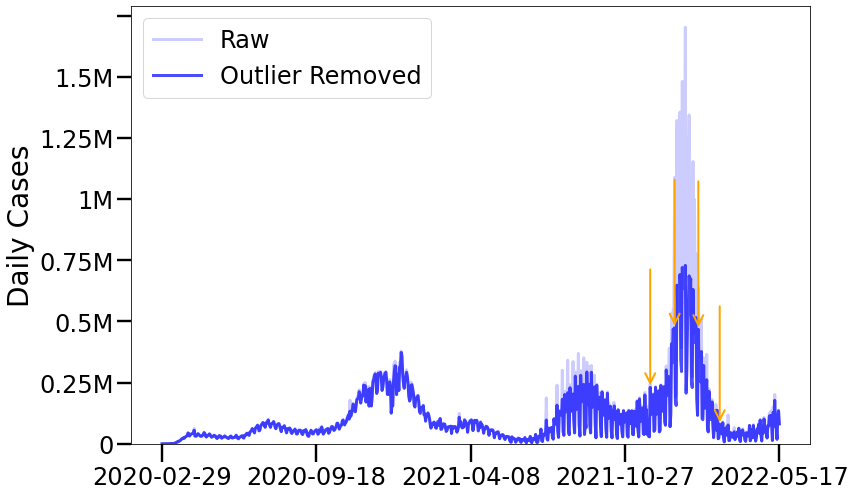

In [66]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.plot(dates, total_raw[target], color='blue', label='Raw', alpha=0.2)
plt.plot(dates, total_cleaned[target], color='blue', label='Outlier Removed', alpha=0.7)
# plt.plot(dates, total_smoothed[target], color='orange', label='7-days moving averaged', linewidth=3.5)
plt.ylim(bottom=0)

x_first_tick = dates.min()
x_last_tick = dates.max()
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
# plt.xticks(rotation = 15)

arrowprops = dict(arrowstyle="simple, head_length=0.5, head_width=0.3, tail_width=0.1")
splits =  {
    'Primary': [to_datetime('2021-11-29'), (0, 120)],
    'Rising 3rd Wave': [to_datetime('2021-12-31'), (0, 150)],
    'Falling 3rd Wave': [to_datetime('2022-01-31'), (0, 150)],
    'Post 3rd Wave': [to_datetime('2022-02-28'), (0, 120)]
}
for index, split in enumerate(splits):
    x = splits[split][0]
    y = df[df[x_column]==x][target].values[0]
    ax.annotate('', 
        xy=(x, y),
        xytext=splits[split][1], 
        textcoords='offset points',
        size=25, 
        va="center",ha='center',
        arrowprops=dict(arrowstyle="->", color='orange',lw=2, connectionstyle="arc3"),
        color='black'
    )

if scale>1:
    if scale==1e3 or scale==1e6:
        label_text = [] 
        if scale ==1e3: unit = 'K'
        else: unit = 'M'

        for loc in plt.yticks()[0]:
            if loc == 0:
                label_text.append('0')
            else:
                label_text.append(f'{loc/scale:0.5g}{unit}') 

        ax.set_yticklabels(label_text)
        plt.ylabel(f'Daily {target}')
    else:
        ax.yaxis.set_major_formatter(get_formatter(scale))
        if scale==1e3: unit = 'in thousands'
        elif scale==1e6: unit = 'in millions'
        else: unit = f'x {scale:.0e}'

        plt.ylabel(f'Daily {target} ({unit})')
else:
    plt.ylabel(f'Daily {target}')

fig.tight_layout()
plt.legend(loc='upper left')

plt.savefig(os.path.join(figPath, 'combined_ground_truth_3.jpg'), dpi=DPI)
plt.show()

In [68]:
to_datetime('05-17-2022') - to_datetime('02-29-2020')

Timedelta('808 days 00:00:00')

In [ ]:
# train_start = to_datetime('03-10-2020')
# validation_start = to_datetime('01-15-2022')
# test_start= to_datetime('04-16-2022')
# test_end = to_datetime('07-28-2022')

# train_days = (validation_start - train_start).days
# val_days = (test_start  - validation_start).days
# test_days = (test_end - test_start).days + 1
# train_days,train_days%13, val_days,val_days%13, test_days, test_days%13